In [47]:
from mpmath import mp
import matplotlib.pyplot as plt

mp.dps = 100  # Set desired precision

plus_configs = [
    ([1,1,1], lambda J1, J2: 2*J1 + J2),
    ([1,1,-1], lambda J1, J2: -J2),
    ([1,-1,1], lambda J1, J2: -2*J1 + J2),
    ([-1,1,1], lambda J1, J2: -J2)
]

minus_configs = [
    ([-1,-1,-1], lambda J1, J2: 2*J1 + J2),
    ([-1,-1,1], lambda J1, J2: -J2),
    ([-1,1,-1], lambda J1, J2: -2*J1 + J2),
    ([1,-1,-1], lambda J1, J2: -J2)
]

def mp_logsumexp(values):
    if not values:
        return mp.ninf
    max_val = max(values)
    sum_exp = mp.mpf(0)
    for v in values:
        sum_exp += mp.exp(v - max_val)
    return max_val + mp.log(sum_exp)

def get_J(d, J0, n):
    if d <= 0:
        return mp.mpf(0)
    return mp.mpf(J0) / mp.power(mp.mpf(d), mp.mpf(n))

def compute_J_prime(start, J0, n):
    J1 = get_J(1, J0, n)
    J2 = get_J(2, J0, n)
    distances = []
    for iL in range(3):
        for iR in range(3):
            d = (start + iR) - (1 + iL)
            distances.append((iL, iR, d))

    def collect_totals(is_pp):
        confsR = plus_configs if is_pp else minus_configs
        totals = []
        for spinsL, El_func in plus_configs:
            El = El_func(J1, J2)
            for spinsR, Er_func in confsR:
                Er = Er_func(J1, J2)
                Eint = mp.mpf(0)
                for iL, iR, d in distances:
                    sign = mp.mpf(spinsL[iL] * spinsR[iR])
                    Eint += sign * get_J(d, J0, n)
                total = El + Er + Eint
                totals.append(total)
        return totals

    totals_pp = collect_totals(True)
    totals_pm = collect_totals(False)
    log_R_pp = mp_logsumexp(totals_pp)
    log_R_pm = mp_logsumexp(totals_pm)
    if log_R_pm == mp.ninf:
        return mp.inf
    return mp.mpf('0.5') * (log_R_pp - log_R_pm)

def compute_J_prime_func(start, J_func):
    J1 = J_func(1)
    J2 = J_func(2)
    distances = []
    for iL in range(3):
        for iR in range(3):
            d = (start + iR) - (1 + iL)
            distances.append((iL, iR, d))
    
    def collect_totals(is_pp):
        confsR = plus_configs if is_pp else minus_configs
        totals = []
        for spinsL, El_func in plus_configs:
            El = El_func(J1, J2)
            for spinsR, Er_func in confsR:
                Er = Er_func(J1, J2)
                Eint = mp.mpf(0)
                for iL_idx, iR_idx, d in distances:
                    sign = mp.mpf(spinsL[iL_idx] * spinsR[iR_idx])
                    Eint += sign * J_func(d)
                total = El + Er + Eint
                totals.append(total)
        return totals
    
    totals_pp = collect_totals(True)
    totals_pm = collect_totals(False)
    log_R_pp = mp_logsumexp(totals_pp)
    log_R_pm = mp_logsumexp(totals_pm)
    if log_R_pm == mp.ninf:
        return mp.inf
    return mp.mpf('0.5') * (log_R_pp - log_R_pm)


def plot_first_renormalized_J(max_k, J0, n):
    ks = []
    Jps = []
    for k in range(1, max_k + 1):
        start = 4 + 3 * (k - 1)
        Jp = compute_J_prime(start, J0, n)
        ks.append(k)
        Jps.append(Jp)
        print(f"For cluster {k} (right starting at {start}), J' = {Jp}")
    
    plt.figure()
    plt.plot(ks, [float(j) for j in Jps], marker='o')
    plt.xlabel('Cluster number k')
    plt.ylabel("Renormalized bond J'")
    plt.title(f"J' vs k for J0={J0}, n={n}")
    plt.grid(True)
    plt.show()

def plot_non_renormalized_J(J0, n, max_r=30):
    rs = list(range(1, max_r + 1))
    Js = [get_J(r, J0, n) for r in rs]
    
    plt.figure()
    plt.plot(rs, [float(j) for j in Js], marker='o')
    plt.xlabel('Distance r')
    plt.ylabel("Non-renormalized J(r)")
    plt.title(f"J(r) = {J0} / r^{n} vs r")
    plt.grid(True)
    plt.show()

def plot_both(J0, n, max_k=10):
    # Non-renormalized
    rs = list(range(1, max_k + 1))
    Js = [get_J(r, J0, n) for r in rs]
    
    # Renormalized
    effective_rs = list(range(1, max_k + 1))
    Jps = []
    for k in range(1, max_k + 1):
        start = 4 + 3 * (k - 1)
        Jp = compute_J_prime(start, J0, n)
        Jps.append(Jp)
        print(f"For cluster {k} (effective r={effective_rs[k-1]}), J' = {Jp}")
    
    plt.figure()
    plt.plot(rs, [float(j) for j in Js], label='Non-renormalized J(r)', marker='o', linestyle='-')
    plt.plot(effective_rs, [float(j) for j in Jps], label='Renormalized J\'(r)', marker='x', linestyle='--')
    plt.xlabel('Distance r')
    plt.ylabel('J')
    plt.title(f"Non-renormalized and Renormalized J vs r for J0={J0}, n={n}")
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_rg_flow(J0, n, max_k, num_steps, show_first=0, num_r_to_plot=5):
    J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
    rs = list(range(1, max_k + 1))
    initial_Js = [J_func(r) for r in rs]
    all_Js = [initial_Js]
    
    if show_first > 0:
        print("Step 0 (initial):")
        for i in range(min(show_first, len(initial_Js))):
            print(f"  J({i+1}) = {initial_Js[i]}")
    
    for step in range(1, num_steps + 1):
        Jps = []
        for r in rs:
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func)
            Jps.append(Jp)
        all_Js.append(Jps)
        
        if show_first > 0:
            print(f"Step {step}:")
            for i in range(min(show_first, len(Jps))):
                print(f"  J({i+1}) = {Jps[i]}")
        
        # Update J_func for next step
        J_dict = {r: Jps[r-1] for r in rs}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
    
    # Plot J vs RG step for first num_r_to_plot r
    plt.figure()
    steps = range(len(all_Js))
    for r_idx in range(min(num_r_to_plot, max_k)):
        Js_step = [all_Js[s][r_idx] for s in steps]
        plt.plot(steps, [float(j) for j in Js_step], label=f'r={r_idx+1}', marker='o')
    plt.xlabel('RG Step')
    plt.ylabel('J(r)')
    plt.title(f'RG Flow for J={J0}, n={n}')
    plt.xticks(steps)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_rg_steps_vs_r(J0, n, max_k=10, num_steps=1, plot_up_to_r=None):
    J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
    rs = list(range(1, max_k + 1))
    all_Js = [[J_func(r) for r in rs]]
    
    for step in range(1, num_steps + 1):
        Jps = []
        for r in rs:
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func)
            Jps.append(Jp)
        all_Js.append(Jps)
        
        # Update J_func for next step
        J_dict = {r: Jps[r-1] for r in rs}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
    
    up_to = plot_up_to_r if plot_up_to_r is not None else max_k
    plot_rs = list(range(1, up_to + 1))
    
    # Plot J vs r for each RG step
    plt.figure()
    for step in range(num_steps + 1):
        Js = all_Js[step][:up_to]
        plt.plot(plot_rs, [float(j) for j in Js], label=f'Step {step}', marker='o')
    plt.xlabel('Distance r')
    plt.ylabel('J(r)')
    plt.title(f'J(r) vs r for RG steps, J0={J0}, n={n}')
    plt.legend()
    plt.grid(True)
    plt.show()

For cluster 1 (effective r=1), J' = 2.612859980397126533804122814559114536191813823134036612867749153238896857540029315546432468507598941
For cluster 2 (effective r=2), J' = 0.2378642252698399730853468711795307551457689697788450236375987384444328854354697859767585347821028751
For cluster 3 (effective r=3), J' = 0.07790142492637178816745758103870120549680942137203984174059733701045394526319872358001130803740699312
For cluster 4 (effective r=4), J' = 0.03670224438950387901394864697437705141663375032015777466707500030334289073971620926534284156197009298
For cluster 5 (effective r=5), J' = 0.02069567564507408010572319511410471671973554010851443628660562501363853889294716629720274476480971847
For cluster 6 (effective r=6), J' = 0.01301428287005682570723893966947852101149786623928960485332111146966136209443302776883341524365399658
For cluster 7 (effective r=7), J' = 0.008809560697706013464419261808185085528650299256920462525391653020146362451650475028623110715755169505
For cluster 8 (effecti

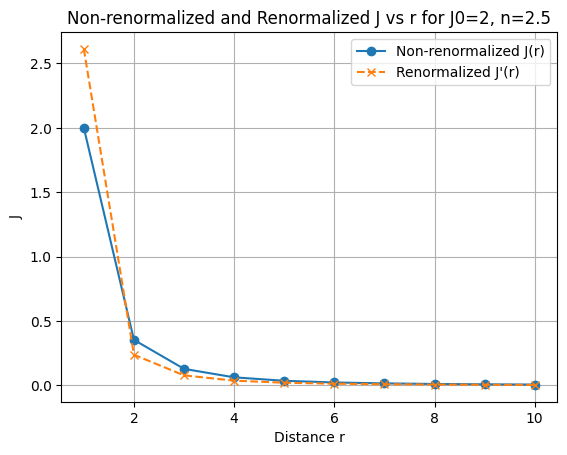

In [36]:
plot_both(2, 2.5, max_k=10)

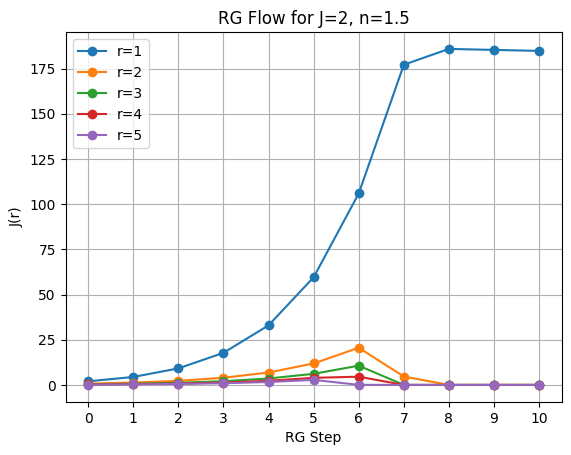

In [55]:
generate_rg_flow(
    J0=2, n=1.5,
    max_k=1000, num_steps=10,
    show_first=0, num_r_to_plot=5
)

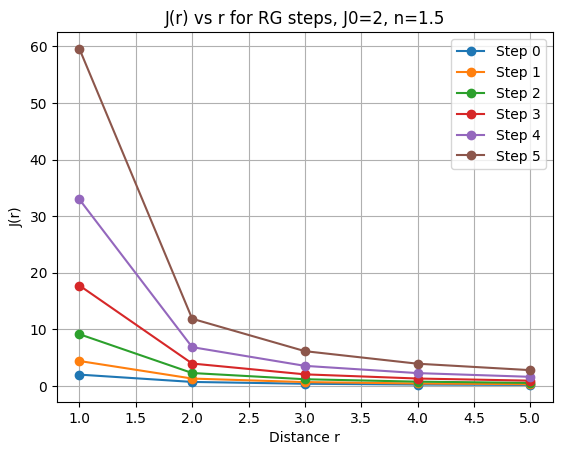

In [58]:
plot_rg_steps_vs_r(
    J0=2, n=1.5,
    max_k=1000, num_steps=5, plot_up_to_r=5
)